execute_notebook : A method to load and execute another notebook in this notebook's namespace

cite: http://nbviewer.jupyter.org/gist/minrk/5491090/analysis.ipynb

Call it for your notebook that want to import here.

In [199]:
import io
from nbformat import current

def execute_notebook(nbfile):
    
    with io.open(nbfile) as f:
        nb = current.read(f, 'json')
    
    ip = get_ipython()
    
    for cell in nb.worksheets[0].cells:
        if cell.cell_type != 'code':
            continue
        ip.run_cell(cell.input)
execute_notebook("distributions_fit_and_likelihood.ipynb")

Necessary packages and libraries to connect to Database

In [200]:
twitter_db = 'twitterGender'
import MySQLdb
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.engine.url import URL
connection = MySQLdb.connect (db = twitter_db, read_default_file="/home/fatal/.my.cnf")
cursor = connection.cursor ()
small_val = 0.01

Global Initializations

In [169]:
DISTRIBUTIONS = [
    'norm', 'lognorm', 'powerlaw', 'zin_norm', 'zin_lognorm', 'zin_powerlaw', 'bernoulli'
]
kfold = 10
labels = 2

# Generate k random folds of train and test

In [170]:
def generate_kfolds(label_table_name):
    # Load DATA from DB
    cursor.execute ('select group_id, label from ' + label_table_name)
    id_labels = list(cursor.fetchall())

    group_id_cnt = len(id_labels)
    print ("Total number of individuals: " + str(group_id_cnt))
    # generating k-folds of ids
    #random.shuffle() works for lists
    np.random.shuffle(id_labels)
    #id_labels = id_labels.sample(frac=1)

    train_fold = [[0 for x in range(labels)] for y in range(kfold)]
    test_fold = [[0 for x in range(labels)] for y in range(kfold)]
    label_prior_prob = [[0 for x in range(labels)] for y in range(kfold)]

    for k in range(kfold):
        test_start = int(group_id_cnt*k/kfold)
        test_end = int(group_id_cnt*(k+1)/kfold)
        # Separate train and test
        test_kth_fold = id_labels[test_start: test_end]
        train_kth_fold = id_labels[0: test_start] + id_labels[test_end:group_id_cnt] 
        total = len(train_kth_fold)
        for l in range(labels): # For each fold, separate data with different labels
            train_fold[k][l] = [int(t[0]) for t in train_kth_fold if t[1] == l]
            label_prior_prob[k][l] = len(train_fold[k][l])/total
            test_fold[k][l] = [int(t[0]) for t in test_kth_fold if t[1] == l]
    return (label_prior_prob, train_fold, test_fold)

 # Build Naive Bayes classifier for each fold

 table_name: Name of the feature table
 
 ### Arguments
 * kfold: number of folds
 * labels: number of labels
 * train_fold: a k by l array. k fold of train set divided based on their labels
 
### Returns
params: a k by l by # of dist array. parameters of each distribution for each train set in each category of labels

In [171]:
import random
def buildNaiveBayes(table_name, train_fold):
    kfold = len(train_fold)
    labels = len(train_fold[0])
    params = [[{} for l in range(labels)] for k in range(kfold)]
    defaults = [[init_default() for l in range(labels)] for k in range(kfold)]
    cntr = 1
    query_time = 0
    fit_time = 0
        
    stime = time.time()
    # Load list of distinct features
    cursor.execute('select feat, count(*) cnt from ' + table_name + ' group by feat')
    features = list(cursor.fetchall())
    feat_cnt = len(features)
    print(str(feat_cnt) + ' unique features' )
    
    # Load data, feature by feature, and set distribution parameters for each quadruple
    # (fold, gender, feature, dist)
    problematic = {}
    for eachfeat in features:
        feat = eachfeat[0]
        qs = time.time()
        feat2search = feat.replace("'", "''").replace("%", "%%").replace("\\", "\\\\")
        GROUP_ID = 0; FEAT = 1; VALUE=2; GROUP_NORM = 3
        fetch_data_query = "select group_id, feat, value, group_norm from " + \
        table_name + " where feat = '" + feat2search + "'"
        cursor.execute(fetch_data_query)
        raw_df = list(cursor.fetchall())
        qe = time.time()
        
        train = {}        
        for row in raw_df:
            train[int(row[GROUP_ID])] = [row[VALUE], row[GROUP_NORM]]

        for k in range(kfold):
            for l in range(labels):
                params[k][l][feat] = {}
                # select group_norm and value of those group_ids in train_fold[k][l]
                aa = time.time()
                train_count, train_grpnrm, train_count_zero, train_grpnrm_zero = [], [], [], []
                for t in train_fold[k][l]:
                    if t in train:
                        train_count += [train[t][0]] # value
                        train_grpnrm += [train[t][1]] # group_norm
                    else:
                        train_grpnrm_zero += [0]
                        train_count_zero += [0]
                train_grpnrm_zero += train_grpnrm 
                train_count_zero += train_count 
                if len(train_count) <= 1:
                    problematic[feat] = True
                defaults[k][l] = update_default(train_grpnrm_zero, defaults[k][l]) # calc default
                for dist in DISTRIBUTIONS:
                    if dist == 'binomial' or dist == 'bernoulli':
                        params[k][l][feat][dist] = mle(train_count_zero, dist) # calc MLE                        
                    elif 'zin' in dist:
                        params[k][l][feat][dist] = mle(train_grpnrm_zero, dist) # calc MLE
                    else:
                        params[k][l][feat][dist] = mle(train_grpnrm, dist) # calc MLE
                    
                    #if dist == 'zin_norm' and random.randint(0, 10) == 0:
                    #    plt.hist(train_grpnrm_zero, bins=200)
        beste = time.time()
        query_time += (qe-qs)
        fit_time += (beste-qe)
        print '\r', str(cntr) + ' out of ' + str(feat_cnt) + ', ' + feat + ', ' + str(round(beste-qe, 2)),
        cntr += 1
    etime = time.time()
    print
    print('overall time: ' + str(round(etime-stime)) + 's -> I/O time: ' + str(round(query_time)) + \
          's, run time: ' + str(round(fit_time)) + 's') 
    print ("problematic length:{}".format(len(problematic.keys())))
    print problematic.keys()
    return params, defaults

# Test Naive Bayes for all Distributions

In [189]:
import math
from operator import itemgetter
from itertools import groupby

def test_naiveBayes(table_name, test_fold, label_prior_prob, params, defaults):
    kfold = len(test_fold)
    labels = len(test_fold[0])
    tp = {}
    total = 0
    label_tp = [0] * labels
    label_total = [0] * labels
    # as we should have a distribution for all features in all kfolds and labels, it doesn't matter which k or l
    # we choose to get list of all features from 
    all_feats = set(params[0][0].keys())
    for l in range(labels):
        label_tp[l] = {}
        for dist in DISTRIBUTIONS:
            tp[dist] = 0
            label_tp[l][dist] = 0
    group_id_cnt = 0
    for k in range(kfold):
        for l in range(labels):
            group_id_cnt += len(test_fold[k][l])
    print ("Total number of test cases: " + str(group_id_cnt))
    cntr = 1
    query_total_time = 0
    run_time = 0
    st = time.time()
    for k in range(kfold):
        for test_l in range(labels): 
            qs = time.time()
            GROUP_ID = 0; FEAT = 1; VALUE=2; GROUP_NORM = 3
            fetch_data_query = "select group_id, feat, value, group_norm from " + table_name + \
                " where group_id in ("+str(test_fold[k][test_l])[1:-1]+")"
            cursor.execute(fetch_data_query)
            test_df = cursor.fetchall()
            qe = time.time()
            query_total_time += (qe - qs)
            # separate results into groups of all features for each group_id
            grps = {}
            for t in test_df:
                key = int(t[GROUP_ID])
                # I'll add all four just to keep indexing for static values GROUP_ID, FEAT, VALUE, & GROUP_NORM
                if key in grps:
                    grps[key] += [[key, t[FEAT], t[VALUE], t[GROUP_NORM]]] 
                else:
                    grps[key] = [[key, t[FEAT], t[VALUE], t[GROUP_NORM]]]
            for key in grps:
                s1 = time.time()
                # select features that have'nt been used by this id
                zero_feats = all_feats - set([g[2] for g in grps[key]]) 
                t3 = time.time()
                for dist in DISTRIBUTIONS:
                    max_prob = float("-inf")
                    best_label = -1
                    for l in range(labels): # go through all classes to find best class as the match label
                        label_prob = np.log(label_prior_prob[k][l])     
                        ll = label_prob
                        t4 = time.time()
                        for row in grps[key]: # go over all available features of an individual
                            if params[k][l][row[FEAT]][dist]['cnt'] > 1:
                                if dist == 'binomial' or dist == 'bernoulli':
                                    data = row[VALUE]
                                else:
                                    data = row[GROUP_NORM]
                                label_prob += np.log(singleval_pdmf(data , dist, \
                                                                params[k][l][row[FEAT]][dist], defaults[k][l]))
                            #if dist == 'zin_norm' and math.isnan(label_prob):
                            #    pdb.set_trace()
                            #    print("something")
                        t5 = time.time()
                        if dist == 'binomial':
                            for feat in zero_feats: # go over all non-available features of an individual
                                label_prob += params[k][l][feat][dist]['cnt']*params[k][l][feat][dist]['logp0']
                            
                        if 'zin' in dist or dist == 'bernoulli':
                            for feat in zero_feats: # go over all non-available features of an individual
                                label_prob += params[k][l][feat][dist]['logp0']
                        t6 = time.time()
                        #if test_l == 1 and dist == 'zin_norm':
                        #    print ("{}, {}, {}".format(l, label_prob, ll))
                        if label_prob > max_prob: # choose best label with maximum probability
                            best_label = l
                            max_prob = label_prob
                    # Track correct classifications as tp:True Positive
                    if best_label == test_l:
                        tp[dist] += 1
                        label_tp[test_l][dist] += 1
                e1 = time.time()
                print '\r' + str(cntr) + ' out of ' + str(group_id_cnt), str(round(e1-s1, 2)), 
                cntr += 1
                # Track total number of test cases
                total += 1
                label_total[test_l] += 1
            run_time += (time.time() - qe)
    et = time.time()
    total_time = et-st
    print 
    print ("overall time: " + str(round(total_time)) + "s -> I/O time: " + str(round(query_total_time)) + \
           "s, run time: " + str(round(run_time)) + "s")
    return (total, label_total, tp, label_tp)

# Table Names

It's important that table_name and label_table_name be synchronized together. 
That's why I put the definition of these two tables together in one chunck.

Table_name is the name of the feature table we want to analyze which can be in each of the cnty, user, or message level. Depending on the level of feature table, label_table_name should be the name of the table containing list of group_ids and labels in the same level.

In [196]:
c_label_table_name = "cntygndr_uwt1k_upc30_ctw5k"
cliwc_table_name = "feat$cat_LIWC2007$cntymsg_u1kupc30c5k$cnty$16to16"
ctopic_table_name = "feat_topic_cnty_freqfeat_u1kupc30c5k"
c1gram_table_name = "feat_1gram_cnty_freqfeat_u1kupc30c5k"

u_label_table_name = "usrgndr_uwt1k_upc30_ctw5k"
uliwc_table_name = "feat$cat_LIWC2007$usrmsg_u1kupc30c5k$user_id$16to16"
utopic_table_name = "feat_topic_usr_freqfeat_u1kupc30c5k"
u1gram_table_name = "feat_1gram_usr_freqfeat_u1kupc30c5k"

m_label_table_name = "msggndr_uwt1k_upc30_ctw5k"
mliwc_table_name = "feat$cat_LIWC2007$msg_u1kupc30c5k$message_id$16to16"
mtopic_table_name = "feat_topic_msg_freqfeat_u1kupc30c5k"
m1gram_table_name = "feat_1gram_msg_freqfeat_u1kupc30c5k"

# Define all kfolds train and test in each level

In [174]:
c_label_prior_prob, c_train_fold, c_test_fold = generate_kfolds(c_label_table_name)

u_label_prior_prob, u_train_fold, u_test_fold = generate_kfolds(u_label_table_name)

m_label_prior_prob, m_train_fold, m_test_fold = generate_kfolds(m_label_table_name)

Total number of individuals: 280
Total number of individuals: 5044
Total number of individuals: 5044


# Train


TOPICS, COUNTY
200 unique features
200 out of 200, 997, 0.15
overall time: 73.0s -> I/O time: 0.0s, run time: 73.0s
problematic length:0
[]

TOPICS, USER
742 unique features
742 out of 742, 997, 0.35
overall time: 368.0s -> I/O time: 33.0s, run time: 334.0s
problematic length:0
[]

TOPICS, MESSAGE
742 unique features
742 out of 742, 997, 0.18
overall time: 258.0s -> I/O time: 3.0s, run time: 254.0s
problematic length:0
[]


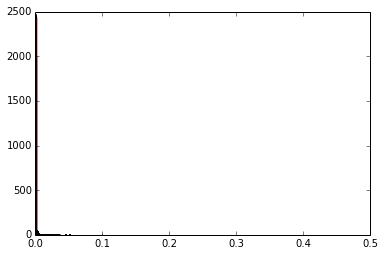

In [201]:
# LIWC
print '\nLIWC, COUNTY'; cliwc_params, cliwc_defaults = buildNaiveBayes(cliwc_table_name, c_train_fold)
print '\nLIWC, USER'; uliwc_params, uliwc_defaults = buildNaiveBayes(uliwc_table_name, u_train_fold)
print '\nLIWC, MESSAGE'; mliwc_params, mliwc_defaults = buildNaiveBayes(mliwc_table_name, m_train_fold)

# TOPICS
print '\nTOPICS, COUNTY'; ctopic_params, ctopic_defaults = buildNaiveBayes(ctopic_table_name, c_train_fold)
print '\nTOPICS, USER'; utopic_params, utopic_defaults = buildNaiveBayes(utopic_table_name, u_train_fold)
print '\nTOPICS, MESSAGE'; mtopic_params, mtopic_defaults = buildNaiveBayes(mtopic_table_name, m_train_fold)

# 1GRAMS
print '\n1GRAM, COUNTY'; c1gram_params, c1gram_defaults = buildNaiveBayes(c1gram_table_name, c_train_fold)
print '\n1GRAM, USER'; u1gram_params, u1gram_defaults = buildNaiveBayes(u1gram_table_name, u_train_fold)
print '\n1GRAM, MESSAGE'; m1gram_params, m1gram_defaults = buildNaiveBayes(m1gram_table_name, m_train_fold)


# LIWC , COUNTY

In [186]:
cliwc_tot, cliwc_ltot, cliwc_tp, cliwc_ltp = \
test_naiveBayes(cliwc_table_name, c_test_fold, c_label_prior_prob, cliwc_params, cliwc_defaults)

Total number of test cases: 280

overall time: 2.0s -> I/O time: 0.0s, run time: 2.0s


# LIWC, USER

In [187]:
uliwc_tot, uliwc_ltot, uliwc_tp, uliwc_ltp = \
test_naiveBayes(uliwc_table_name, u_test_fold, u_label_prior_prob, uliwc_params, uliwc_defaults)

Total number of test cases: 5044

overall time: 39.0s -> I/O time: 2.0s, run time: 37.0s


# LIWC, MESSAGE

In [188]:
mliwc_tot, mliwc_ltot, mliwc_tp, mliwc_ltp = \
test_naiveBayes(mliwc_table_name, m_test_fold, m_label_prior_prob, mliwc_params, mliwc_defaults)

Total number of test cases: 5044

overall time: 9.0s -> I/O time: 1.0s, run time: 9.0s


# LIWC, Compare Results

In [206]:
row_format ="{:>13}" * (len(DISTRIBUTIONS) + 1)
print row_format.format("", *DISTRIBUTIONS)

#for team, row in zip(teams_list, data):
#    print row_format.format(team, *row)
row = ['county']
for k, v in cliwc_tp.iteritems():
    row += [round(v/cliwc_tot, 2)]
print row_format.format(*row)

row = ['user']
for k, v in uliwc_tp.iteritems():
    row += [round(v/uliwc_tot, 2)]
print row_format.format(*row)

row = ['message']
for k, v in mliwc_tp.iteritems():
    row += [round(v/mliwc_tot, 2)]
print row_format.format(*row)

for l in range(labels):
    print "\n" + "\t"*3 +"######### gender = {} #########".format(l)
    row = ['county']
    for k, v in cliwc_ltp[l].iteritems():
        row += [round(v/cliwc_ltot[l], 2)]
    print row_format.format(*row)

    row = ['user']
    for k, v in uliwc_ltp[l].iteritems():
        row += [round(v/uliwc_ltot[l], 2)]
    print row_format.format(*row)

    row = ['message']
    for k, v in mliwc_ltp[l].iteritems():
        row += [round(v/mliwc_ltot[l], 2)]
    print row_format.format(*row)

                      norm      lognorm     powerlaw     zin_norm  zin_lognorm zin_powerlaw    bernoulli
       county         0.57         0.57         0.51         0.56         0.56         0.51         0.56
         user         0.54         0.55         0.54         0.54         0.54         0.46         0.65
      message         0.48         0.55         0.46         0.48         0.51          0.5         0.53

			######### gender = 0 #########
       county         0.52         0.57         0.05         0.36         0.51         0.06         0.56
         user          1.0         0.36          1.0          1.0          1.0          0.0         0.61
      message         0.19         0.79         0.04         0.15         0.45         0.36         0.76

			######### gender = 1 #########
       county         0.63         0.57         0.97         0.76         0.61         0.96         0.57
         user          0.0         0.77          0.0          0.0          0.0          1.

# TOPIC, COUNTY

In [202]:
ctopic_tot, ctopic_ltot, ctopic_tp, ctopic_ltp = \
test_naiveBayes(ctopic_table_name, c_test_fold, c_label_prior_prob, ctopic_params, ctopic_defaults)

Total number of test cases: 280
280 out of 280 0.03
overall time: 7.0s -> I/O time: 0.0s, run time: 7.0s


# TOPIC, USER

In [203]:
utopic_tot, utopic_ltot, utopic_tp, utopic_ltp = \
test_naiveBayes(utopic_table_name, u_test_fold, u_label_prior_prob, utopic_params, utopic_defaults)

Total number of test cases: 5044
5044 out of 5044 0.1
overall time: 514.0s -> I/O time: 19.0s, run time: 495.0s


# TOPIC, MESSAGE

In [204]:
mtopic_tot, mtopic_ltot, mtopic_tp, mtopic_ltp = \
test_naiveBayes(mtopic_table_name, m_test_fold, m_label_prior_prob, mtopic_params, mtopic_defaults)

Total number of test cases: 5044
4817 out of 5044 0.03
overall time: 92.0s -> I/O time: 3.0s, run time: 89.0s


# TOPIC, Compare Results

In [207]:
row_format ="{:>13}" * (len(DISTRIBUTIONS) + 1)
print row_format.format("", *DISTRIBUTIONS)

#for team, row in zip(teams_list, data):
#    print row_format.format(team, *row)
row = ['county']
for k, v in ctopic_tp.iteritems():
    row += [round(v/ctopic_tot, 2)]
print row_format.format(*row)

row = ['user']
for k, v in utopic_tp.iteritems():
    row += [round(v/utopic_tot, 2)]
print row_format.format(*row)

row = ['message']
for k, v in mtopic_tp.iteritems():
    row += [round(v/mtopic_tot, 2)]
print row_format.format(*row)

for l in range(labels):
    print "\n" + "\t"*3 +"######### gender = {} #########".format(l)
    row = ['county']
    for k, v in ctopic_ltp[l].iteritems():
        row += [round(v/ctopic_ltot[l], 2)]
    print row_format.format(*row)

    row = ['user']
    for k, v in utopic_ltp[l].iteritems():
        row += [round(v/utopic_ltot[l], 2)]
    print row_format.format(*row)

    row = ['message']
    for k, v in mtopic_ltp[l].iteritems():
        row += [round(v/mtopic_ltot[l], 2)]
    print row_format.format(*row)

                      norm      lognorm     powerlaw     zin_norm  zin_lognorm zin_powerlaw    bernoulli
       county          0.6          0.6          0.5         0.56         0.53          0.5         0.51
         user         0.54         0.55         0.54         0.54         0.53         0.46         0.58
      message         0.52         0.54         0.51          0.5         0.51         0.54         0.51

			######### gender = 0 #########
       county         0.67         0.71         0.11         0.66         0.58          0.1         0.57
         user          1.0         0.35          1.0          1.0         0.98          0.0         0.42
      message         0.45         0.58         0.47         0.35         0.55          0.8         0.57

			######### gender = 1 #########
       county         0.54         0.49         0.89         0.46         0.48         0.91         0.46
         user          0.0          0.8          0.0          0.0          0.0          1.

# 1GRAM, COUNTY

In [190]:
c1gram_tot, c1gram_ltot, c1gram_tp, c1gram_ltp = \
test_naiveBayes(c1gram_table_name, c_test_fold, c_label_prior_prob, c1gram_params, c1gram_defaults)

Total number of test cases: 280
280 out of 280 0.02
overall time: 7.0s -> I/O time: 0.0s, run time: 7.0s


# 1GRAM, USER

In [191]:
u1gram_tot, u1gram_ltot, u1gram_tp, u1gram_ltp = \
test_naiveBayes(u1gram_table_name, u_test_fold, u_label_prior_prob, u1gram_params, u1gram_defaults)

Total number of test cases: 5044
5044 out of 5044 0.05
overall time: 256.0s -> I/O time: 9.0s, run time: 247.0s


# 1GRAM, MESSAGE

In [193]:
m1gram_tot, m1gram_ltot, m1gram_tp, m1gram_ltp = \
test_naiveBayes(m1gram_table_name, m_test_fold, m_label_prior_prob, m1gram_params, m1gram_defaults)

Total number of test cases: 5044
4983 out of 5044 0.0
overall time: 19.0s -> I/O time: 0.0s, run time: 19.0s


# 1GRAM, Compare Results

In [208]:
row_format ="{:>13}" * (len(DISTRIBUTIONS) + 1)
print row_format.format("", *DISTRIBUTIONS)

#for team, row in zip(teams_list, data):
#    print row_format.format(team, *row)
row = ['county']
for k, v in c1gram_tp.iteritems():
    row += [round(v/c1gram_tot, 2)]
print row_format.format(*row)

row = ['user']
for k, v in u1gram_tp.iteritems():
    row += [round(v/u1gram_tot, 2)]
print row_format.format(*row)

row = ['message']
for k, v in m1gram_tp.iteritems():
    row += [round(v/m1gram_tot, 2)]
print row_format.format(*row)

for l in range(labels):
    print "\n" + "\t"*3 +"######### gender = {} #########".format(l)
    row = ['county']
    for k, v in c1gram_ltp[l].iteritems():
        row += [round(v/c1gram_ltot[l], 2)]
    print row_format.format(*row)

    row = ['user']
    for k, v in u1gram_ltp[l].iteritems():
        row += [round(v/u1gram_ltot[l], 2)]
    print row_format.format(*row)

    row = ['message']
    for k, v in m1gram_ltp[l].iteritems():
        row += [round(v/m1gram_ltot[l], 2)]
    print row_format.format(*row)

                      norm      lognorm     powerlaw     zin_norm  zin_lognorm zin_powerlaw    bernoulli
       county         0.55         0.58         0.51         0.51         0.57          0.5         0.59
         user         0.55         0.62         0.54         0.54         0.62         0.46         0.58
      message          0.5          0.5          0.5         0.57          0.5          0.5          0.5

			######### gender = 0 #########
       county         0.59         0.64         0.01         0.51         0.63         0.07         0.63
         user          1.0          0.5         0.95          1.0         0.84         0.01         0.42
      message          0.6          0.6         0.38         0.65         0.58         0.38         0.58

			######### gender = 1 #########
       county         0.51         0.53          1.0         0.51         0.51         0.93         0.54
         user         0.01         0.76         0.06          0.0         0.36         0.9